In [1]:
import spotipy
import spotipy.util as util
import pandas as pd 
import numpy as np
import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Manual Imput

playlist_name_1 = 'Lofi Hip Hop'
playlist_name_2 = 'Angsty Teen Phase'

In [1]:
scope = 'user-library-read'
client_id ='a63ddab3e3d147898a0df1d5658f9ee9'
client_secret ='226f21e7e723484f909f768fdadada7c'
redirect_uri ='http://localhost/'

# Profile url: https://open.spotify.com/user/22r6slwbns4u7hkhn3hjhjhyi?si=MX4wzJ3PQeiH_7IKIHHrMA
# Find way so that users don't have to get their link
username = '22r6slwbns4u7hkhn3hjhjhyi'

In [2]:
# Pormpt

token = util.prompt_for_user_token(username, scope = scope, client_id = client_id, client_secret = client_secret, redirect_uri = redirect_uri)

NameError: name 'util' is not defined

In [5]:
token

'BQBmLMDBd55YwSswmX9ylLQxHqlYwEqpsZ0EMvQVhMtMd9H2biWLLd-vMGn2wzTgka0WoF_ZX5uvrA52FmxGBv0KAo2V9N1xtzlRSWiPheV0dChmjKAihdw_PAT7WkN-M2DQxkRlHu5xBZpWyAyDh_Hz46TtF2-6B-MrJ87D5GcqBRQQ_3JIO0fEcR4RuV-MPrRx17doquI5lEhVSdewvQjE3W8By50PjK0ak5TNKYHuYRLbfV9RvyN0e2AhBWLjZDNkDg'

In [266]:
# Get All user's playlists
sp = spotipy.Spotify(auth=token)
playlists = sp.user_playlists(username)


In [267]:
# Get the 2 playlists we care about
for playlist in playlists['items']:
    if(playlist['name'] == playlist_name_1):
        playlist_1 = playlist;
    
    if(playlist['name'] == playlist_name_2):
        playlist_2 = playlist;
    

In [268]:
### HERES A BUNCH OF FUNCTIONS

In [269]:
# return a list of similar tracks for a given playlist
def get_similar_tracks_from_playlist(username_var, playlist_var):
    top_level_tracks = sp.user_playlist(username_var, playlist_var['id'],
                    fields="tracks,next")
    second_level_tracks = top_level_tracks['tracks']
    playlist_var_track_ids = [None]*len(second_level_tracks['items'])
    playlist_var_artist_ids = [None]*len(second_level_tracks['items'])
    # playlist_1_genre_ids = [None]*len(second_level_tracks['items'])
    for i, item in enumerate(second_level_tracks['items']):
        cur_track = item['track']
        playlist_var_track_ids[i] = cur_track['id']
#        playlist_var_artist_ids[i] = cur_track['artists'][0]['id']


## Sometimes we get a track with a "none" value, get rid of these (this could reset indexing, don't rely on indices)
    playlist_var_track_ids = [x for x in playlist_var_track_ids if x != None]

    rec_tracks_list = [None]*int((len(playlist_var_track_ids)/5)-1)
    for i in range(0,len(rec_tracks_list)):
        rec_tracks_list[i] = sp.recommendations(seed_tracks = playlist_var_track_ids[i*5:(i+1)*5])
        
    # rec_tracks_list is a list of lists, each sublist has a track
    # extract out to a single list
    rec_tracks_list_full = [None]*20*len(rec_tracks_list)

    # Iterate over all sets of recommendations from groups of 5 songs
    for i, rec_set in enumerate(rec_tracks_list):

        # Iterate over every track
        for j, tracks in enumerate(rec_set['tracks']):
            rec_tracks_list_full[i*20 + j] = tracks['id']
            #print(tracks['artists'][0]['name'], ': ', tracks['name'], sep = '')

    all_track_ids = pd.DataFrame(np.array(rec_tracks_list_full))
    all_track_ids.columns=['track_id']
    return all_track_ids

In [270]:
def get_track_features(track_df, playlist_name):
    track_df_var = copy.deepcopy(track_df)
    new_cols = list(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'])

    # Create all new columns for feature types
    for col in new_cols:
        # Initialize Column as empty
        track_df_var[col] = np.nan
        # Run over each row
    for i in range(0, len(track_df_var)):
        # Get features for current song
        cur_track_features = sp.audio_features(track_df_var['track_id'][[i]])
        #Insert specific feature into column
        #TODO: This currently calls the sp.audio_features like 10 times for each song (since I do it for each row)
        for col in new_cols:
            track_df_var[col].iloc[i] = cur_track_features[0][col]
    
    # Create column specifying 'playlist_name' - doesn't have to be actual playlist name, just a holder to differentiate playlists
    track_df_var['playlist_name'] = playlist_name
    return track_df_var


In [271]:
def get_tracks_from_playlist(username_var, playlist_var):
    top_level_tracks = sp.user_playlist(username_var, playlist_var['id'],
                    fields="tracks,next")
    second_level_tracks = top_level_tracks['tracks']
    playlist_var_track_ids = [None]*len(second_level_tracks['items'])
    playlist_var_artist_ids = [None]*len(second_level_tracks['items'])
    # playlist_1_genre_ids = [None]*len(second_level_tracks['items'])
    for i, item in enumerate(second_level_tracks['items']):
        cur_track = item['track']
        playlist_var_track_ids[i] = cur_track['id']
#        playlist_var_artist_ids[i] = cur_track['artists'][0]['id']


## Sometimes we get a track with a "none" value, get rid of these (this could reset indexing, don't rely on indices)
    playlist_var_track_ids = [x for x in playlist_var_track_ids if x != None]
    to_return = pd.DataFrame(np.array(playlist_var_track_ids))
    to_return.columns=['track_id']
    return to_return

In [272]:
# DONE WITH FUNCTIONS - PULL TRACK IDS FROM ACTUAL PLAYLIST & CREATE PCA PLOT 
# This should let us see if there's actually a 'difference' in playlists based on the audio_features spotify gives us

In [273]:
# Get tracks from each playlist
playlist_1_track_ids = get_tracks_from_playlist(username, playlist_1)
playlist_2_track_ids = get_tracks_from_playlist(username, playlist_2)

In [274]:
# Get features of tracks from each playlist
p1_features_tmp = get_track_features(playlist_1_track_ids, 'p1')
p2_features_tmp = get_track_features(playlist_2_track_ids, 'p2')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [275]:
# Mode and Key make PCA look weird (at least for graphing) - take them out for time being
# Maybe add back in at some point....?

p1_features = p1_features_tmp.drop(['track_id','mode', 'key'], axis = 1)
p2_features = p2_features_tmp.drop(['track_id','mode', 'key'], axis = 1)


In [276]:
# Combine the 2 playlists (we don't want to do PCA or normalization separately since they would be on different scales)
playlist_comb_features = p1_features.append(p2_features).reset_index()

In [277]:
# PCA TIME
# Separating out the features
x = playlist_comb_features.drop(['playlist_name'], axis = 1)
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
playlists_finalDf = pd.concat([principalDf,  comb_features[['playlist_name']]], axis = 1)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [278]:
# NOW LET'S PLOTS SOME SHIT

# TODO: Figure out better way to plot this...
playlist_1_pc = playlists_finalDf[playlists_finalDf['playlist_name'] == 'p1']
playlist_2_pc = playlists_finalDf[playlists_finalDf['playlist_name'] == 'p2']


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


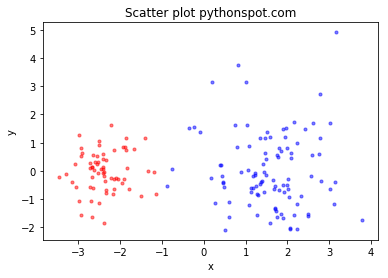

In [279]:

color_1 = (0,0,1)
color_2 = (1,0,0)
area = np.pi*3
plt.scatter(playlist_1_pc['principal component 1'], playlist_1_pc['principal component 2'], s=area, c=color_1, alpha=0.5)
plt.scatter(playlist_2_pc['principal component 1'], playlist_2_pc['principal component 2'], s=area, c=color_2, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

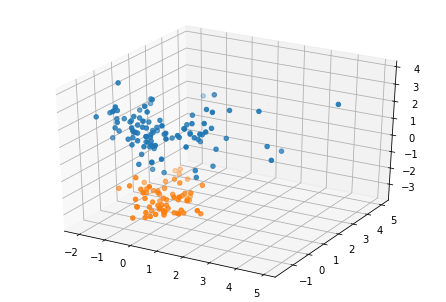

In [280]:
## 3D plot?
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(playlist_1_pc['principal component 2'], playlist_1_pc['principal component 3'], playlist_1_pc['principal component 1'])
ax.scatter(playlist_2_pc['principal component 2'], playlist_2_pc['principal component 3'], playlist_2_pc['principal component 1'])
pyplot.show()

In [ ]:
### NOW WORK ON RECOMMENDATIONS

In [281]:
rec_tracks_p1 = get_similar_tracks_from_playlist(username, playlist_1)
rec_tracks_p2 = get_similar_tracks_from_playlist(username, playlist_2)


In [282]:

p1_rec_features_tmp = get_track_features(rec_tracks_p1, 'p1')
p2_rec_features_tmp = get_track_features(rec_tracks_p2, 'p2')

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [283]:


### Followups
# Do 2 different playlists seed the same songs?
# If so, pick em I guess (see how common it is?)
# Otherwise do distance (a few different methods)

In [284]:
p1_rec_features = p1_rec_features_tmp.drop(['track_id','mode', 'key'], axis = 1)
p2_rec_features = p2_rec_features_tmp.drop(['track_id','mode', 'key'], axis = 1)
playlist_rec_comb_features = p1_rec_features.append(p2_rec_features).reset_index()

In [285]:
x = playlist_rec_comb_features.drop(['playlist_name'], axis = 1)
# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
playlists_rec_finalDf = pd.concat([principalDf,  comb_features[['playlist_name']]], axis = 1)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

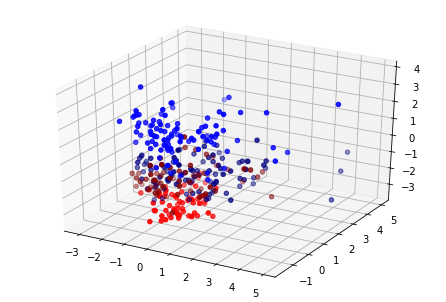

In [292]:
playlist_1_rec_pc = playlists_rec_finalDf[playlists_rec_finalDf['playlist_name'] == 'p1']
playlist_2_rec_pc = playlists_rec_finalDf[playlists_rec_finalDf['playlist_name'] == 'p2']

fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter(playlist_1_pc['principal component 2'], playlist_1_pc['principal component 3'], playlist_1_pc['principal component 1'], c = (0,0,1))
ax.scatter(playlist_2_pc['principal component 2'], playlist_2_pc['principal component 3'], playlist_2_pc['principal component 1'], c = (1,0,0))

ax.scatter(playlist_1_rec_pc['principal component 2'], playlist_1_rec_pc['principal component 3'], playlist_1_rec_pc['principal component 1'], c = (0,0,.5))
ax.scatter(playlist_2_rec_pc['principal component 2'], playlist_2_rec_pc['principal component 3'], playlist_2_rec_pc['principal component 1'], c = (0.5,0,0))
pyplot.show()